### Evaluation notebook

Evaluates on `HPatches` dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, exists
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update
from relfm.utils.visualize import show_images_with_keypoints
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result

In [3]:
data_dir = join(REPO_PATH, "data/hpatches-sequences-release/")
model_ckpt_path = join(REPO_PATH, "checkpoints/r2d2_WASF_N16.pt")

In [4]:
assert isdir(data_dir)
assert exists(model_ckpt_path)

::::::::::::::::::::::::::::::::::::::::::::::::::::::: Evaluating on 116 sequences. :::::::::::::::::::::::::::::::::::::::::::::::::::::::
Launching on CPU

>> Creating net = Quad_L2Net_ConfCFS()
 ( Model size: 486K parameters )
extracting at scale x1.00 =  800x600
extracting at scale x0.84 =  673x505
extracting at scale x0.71 =  566x424
extracting at scale x0.59 =  476x357
extracting at scale x0.50 =  400x300
extracting at scale x0.42 =  336x252
extracting at scale x0.35 =  283x212
extracting at scale x1.00 =  800x600
extracting at scale x0.84 =  673x505
extracting at scale x0.71 =  566x424
extracting at scale x0.59 =  476x357
extracting at scale x0.50 =  400x300
extracting at scale x0.42 =  336x252
extracting at scale x0.35 =  283x212


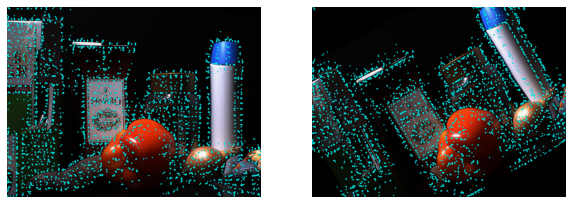

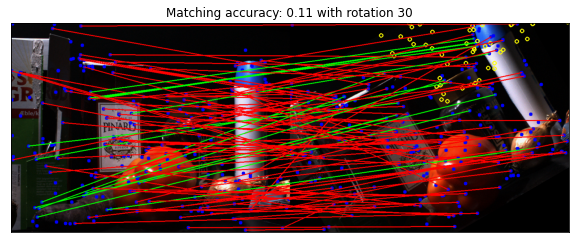

In [7]:
sequences = glob(join(data_dir, "*"))
print_update(f"Evaluating on {len(sequences)} sequences.")
for sequence in sequences:
    # set path to the source image
    img1_path = join(sequence, "1.ppm")
    img1 = Image.open(img1_path)

    # loop over target images
    for i in range(2, 7):
        img2_path = join(sequence, f"{i}.ppm")
        H_path = join(sequence, f"H_1_{i}")
        
        rotation = 30

        img2 = Image.open(img2_path)
        img2 = img2.rotate(rotation)

        H = np.loadtxt(H_path)

        # extract keypoints and descriptors for both images
        outputs = extract_keypoints_modified([img1, img2], model_ckpt_path)

        # get keypoints and descriptors from the outputs
        kps1 = outputs[0]["keypoints"]
        des1 = outputs[0]["descriptors"]

        kps2 = outputs[1]["keypoints"]
        des2 = outputs[1]["descriptors"]

        # show detected keypoints
        show_images_with_keypoints([img1, img2], [kps1, kps2], radius=2)

        # perform matching
        width, height = img2.size
        result = evaluate_matching_with_rotation(
            kp1=kps1,
            des1=des1,
            kp2=kps2,
            des2=des2,
            H=H,
            width=width,
            height=height,
            rotation=rotation,
            return_metadata=True,
            threshold=300.,
        )

        analyze_result(img1, img2, result)
        break
    break